# DoH detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of DoH

Raw data from: CIC-DoHBrw-2020 [1]

-----------------------------------------------------------------------
[1] Mohammadreza MontazeriShatoori et al. Detection of doh tunnels using time-series classification of encrypted traffic. In DASC/PiCom/CBDCom/CyberSciTech 2020, pages 63–70. IEEE, 2020.

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [2]:
df = pd.read_csv("../cnsm_final_datasets/doh_cic.csv")

In [3]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,1.1.1.1.,192.168.20.144,166,0,9009,0,1.585702e+09,1.585702e+09,443,...,13630.165637,0.321156,0.647004,0.257233,0.696817,8.236810,1.332151,0.428524,0.489665,True
1,1,192.168.20.144.,1.1.1.1,248,0,20108,0,1.585702e+09,1.585702e+09,35784,...,9850.682690,0.329699,0.520761,0.288828,0.020163,7.383369,1.543607,-0.511169,0.782838,True
2,2,1.1.1.1.,192.168.20.144,239,0,13795,0,1.585702e+09,1.585702e+09,443,...,24168.822670,0.968015,0.688742,0.249193,0.486452,23.280760,0.969427,0.827844,0.597161,True
3,3,192.168.20.144.,1.1.1.1,372,0,26999,0,1.585702e+09,1.585702e+09,36080,...,19910.802176,0.860933,0.521975,0.281701,0.042755,11.823744,0.965827,0.116021,0.749907,True
4,4,1.1.1.1.,192.168.20.144,197,0,11992,0,1.585702e+09,1.585702e+09,443,...,19832.946195,0.861529,0.674352,0.258972,0.523305,15.915634,1.177049,0.197276,0.464377,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991355,991355,52.50.215.119.,192.168.20.191,12,0,1168,0,1.578933e+09,1.578933e+09,443,...,2686.423343,0.357115,0.549690,0.279789,0.176361,1.515317,0.732219,0.840360,0.168880,False
991356,991356,192.168.20.191.,193.200.65.5,9,0,5915,0,1.578933e+09,1.578933e+09,53993,...,-337596.929634,0.802327,0.217884,NaN,NaN,-841.447379,22842.921830,0.403095,0.000602,False
991357,991357,192.168.20.191.,52.50.215.119,11,0,4608,0,1.578933e+09,1.578933e+09,53994,...,2992.511286,0.360095,0.536066,0.283979,0.116189,1.402746,0.815883,0.462496,0.198089,False
991358,991358,85.194.242.103.,192.168.20.191,9,0,1073,0,1.578933e+09,1.578933e+09,443,...,2156.966910,0.402808,0.541766,0.270578,0.158447,1.553336,0.760355,-0.415611,0.138390,False


In [4]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [5]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in frequency_features: 
        df.replace([np.inf], -1, inplace=True)
        df.replace([-np.inf], -1, inplace=True)
        df.loc[df[F].isnull(), F] = -1
    else:
        df.replace([np.inf], 0, inplace=True)
        df.replace([-np.inf], 0, inplace=True)
        df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [6]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,1.1.1.1.,192.168.20.144,166,0,9009,0,1.585702e+09,1.585702e+09,443,35784,114,60.0,86.469648,7477,-0.137329,60.0,157.00,60,650,590,60,75.850568,62,54.385965,143.145326,0.578313,0.421687,0.624497,3.261260,3.282109,4.192889e-07,4.231219e-07,-0.113402,19.221764,2.343127,0.317710,0.552495,False,0.669892,0.018051,0.532485,0.169912,0.901722,49.012083,40.423646,27.949549,55.803539,288.456537,1.748221,0.001355,2.384186e-05,15.104457,0.115742,False,0.884848,False,0.0,0.532485,14901,1.0,False,0,0.0,5.678451e-07,0.056045,0.214869,0.643393,0.006804,0.009128,0.00032,34.020846,214.042556,5.808420e+04,13630.165637,0.321156,0.647004,0.257233,0.696817,8.236810,1.332151,0.428524,True,True,1
1,1,192.168.20.144.,1.1.1.1,248,0,20108,0,1.585702e+09,1.585702e+09,35784,443,141,91.0,210.409125,44272,0.197517,60.0,169.00,60,3109,3049,60,149.226330,87,61.702128,252.978435,0.669355,0.330645,0.384964,1.577878,11.433725,8.657343e-09,8.710113e-09,-0.486239,159.874916,2.951888,0.371111,0.512742,False,0.751315,0.010699,0.570665,0.159045,0.890264,45.877504,40.408011,31.042470,52.690847,288.457000,1.167842,0.000199,2.861023e-06,15.141317,0.077129,False,1.514170,True,0.0,0.570665,26388,1.0,False,0,0.0,1.725275e-05,0.058853,0.841265,0.330096,0.007971,0.006208,0.00469,39.854884,262.808003,5.089124e+04,9850.682690,0.329699,0.520761,0.288828,0.020163,7.383369,1.543607,-0.511169,True,True,1
2,2,1.1.1.1.,192.168.20.144,239,0,13795,0,1.585702e+09,1.585702e+09,443,36080,117,60.0,122.715117,15059,0.023841,60.0,157.00,60,1271,1211,60,104.884716,69,58.974359,169.865034,0.606695,0.393305,0.464490,2.371346,5.258299,3.894362e-07,3.919001e-07,-0.175258,40.395304,2.239546,0.283456,0.505912,False,0.662955,0.004694,0.658931,0.133629,0.920839,38.541851,30.936951,12.428884,49.501112,288.424106,1.211866,0.000764,1.883507e-05,15.104759,0.080231,False,0.764706,False,0.0,0.658931,18247,1.0,False,0,0.0,4.167497e-07,0.087257,0.141959,0.969803,0.003748,0.009796,0.00004,18.740186,114.032099,1.507063e+05,24168.822670,0.968015,0.688742,0.249193,0.486452,23.280760,0.969427,0.827844,True,True,1
3,3,192.168.20.144.,1.1.1.1,372,0,26999,0,1.585702e+09,1.585702e+09,36080,443,132,91.0,173.000000,29929,0.134426,60.0,169.00,60,3109,3049,91,131.060606,71,53.787879,217.774576,0.647849,0.352151,0.236994,1.763006,13.814363,1.116239e-07,1.120763e-07,-0.321101,235.902877,2.665128,0.312107,0.734491,False,0.713619,0.004014,0.682523,0.124814,0.880879,35.999223,30.941632,12.478980,49.504474,288.423932,0.777423,0.000084,1.907349e-06,15.113732,0.051438,False,1.568733,True,0.0,0.682523,31415,1.0,False,0,0.0,6.947349e-06,0.064438,0.745905,0.861927,0.005450,0.006819,0.00259,27.249376,187.684249,1.127866e+05,19910.802176,0.860933,0.521975,0.281701,0.042755,11.823744,0.965827,0.116021,True,True,1
4,4,1.1.1.1.,192.168.20.144,197,0,11992,0,1.585702e+09,1.585702e+09,443,36106,120,60.0,110

In [7]:
print(f"hod: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

hod: 302627	clear: 688733


In [8]:
df = df[["LABEL_code"] + features].copy()

In [9]:
df.replace([np.inf], 0, inplace=True)
df.replace([-np.inf], 0, inplace=True)

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [11]:
print(f"doh: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

doh: 302627	clear: 688733


In [12]:
df_validation = df.sample(n=100000)
df_features =  df[~df.isin(df_validation)].dropna()

In [13]:
len(df_features)

891360

In [14]:
len(df_features)*0.7

623952.0

In [15]:
len(df_features)*0.3

267408.0

In [16]:
df_features

,LABEL_code,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,DIRECTIONS,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF
0,1.0,166.0,0.0,9009.0,0.0,114.0,60.0,86.469648,7477.0,-0.137329,60.0,157.00,60.0,650.0,590.0,60.0,75.850568,62.0,54.385965,143.145326,0.578313,0.421687,0.624497,3.261260,3.282109,4.192889e-07,4.231219e-07,-0.113402,19.221764,2.343127,0.317710,0.552495,0.0,0.669892,0.018051,0.532485,0.169912,0.901722,49.012083,40.423646,27.949549,55.803539,288.456537,1.748221,0.001355,2.384186e-05,15.104457,0.115742,0.0,0.884848,1.0,0.0,0.0,0.532485,14901.0,0.0,0.0,0.0,5.678451e-07,0.056045,0.214869,0.643393,0.006804,0.009128,0.00032,34.020846,214.042556,5.808420e+04,13630.165637,0.321156,0.647004,0.257233,0.696817,8.236810,1.332151,0.428524,1.0
1,1.0,248.0,0.0,20108.0,0.0,141.0,91.0,210.409125,44272.0,0.197517,60.0,169.00,60.0,3109.0,3049.0,60.0,149.226330,87.0,61.702128,252.978435,0.669355,0.330645,0.384964,1.577878,11.433725,8.657343e-09,8.710113e-09,-0.486239,159.874916,2.951888,0.371111,0.512742,0.0,0.751315,0.010699,0.570665,0.159045,0.890264,45.877504,40.408011,31.042470,52.690847,288.457000,1.167842,0.000199,2.861023e-06,15.141317,0.077129,0.0,1.514170,1.0,1.0,0.0,0.570665,26388.0,0.0,0.0,0.0,1.725275e-05,0.058853,0.841265,0.330096,0.007971,0.006208,0.00469,39.854884,262.808003,5.089124e+04,9850.682690,0.329699,0.520761,0.288828,0.020163,7.383369,1.543607,-0.511169,1.0
2,1.0,239.0,0.0,13795.0,0.0,117.0,60.0,122.715117,15059.0,0.023841,60.0,157.00,60.0,1271.0,1211.0,60.0,104.884716,69.0,58.974359,169.865034,0.606695,0.393305,0.464490,2.371346,5.258299,3.894362e-07,3.919001e-07,-0.175258,40.395304,2.239546,0.283456,0.505912,0.0,0.662955,0.004694,0.658931,0.133629,0.920839,38.541851,30.936951,12.428884,49.501112,288.424106,1.211866,0.000764,1.883507e-05,15.104759,0.080231,0.0,0.764706,1.0,0.0,0.0,0.658931,18247.0,0.0,0.0,0.0,4.167497e-07,0.087257,0.141959,0.969803,0.003748,0.009796,0.00004,18.740186,114.032099,1.507063e+05,24168.822670,0.968015,0.688742,0.249193,0.486452,23.280760,0.969427,0.827844,1.0
3,1.0,372.0,0.0,26999.0,0.0,132.0,91.0,173.000000,29929.0,0.134426,60.0,169.00,60.0,3109.0,3049.0,91.0,131.060606,71.0,53.787879,217.774576,0.647849,0.352151,0.236994,1.763006,13.814363,1.116239e-07,1.120763e-07,-0.321101,235.902877,2.665128,0.312107,0.734491,0.0,0.713619,0.004014,0.682523,0.124814,0.880879,35.999223,30.941632,12.478980,49.504474,288.423932,0.777423,0.000084,1.907349e-06,15.113732,0.051438,0.0,1.568733,1.0,1.0,0.0,0.682523,31415.0,0.0,0.0,0.0,6.947349e-06,0.064438,0.745905,0.861927,0.005450,0.006819,0.00259,27.249376,187.684249,1.127866e+05,19910.802176,0.860933,0.521975,0.281701,0.042755,11.823744,0.965827,0.116021,1.0
4,1.0,197.0,0.0,11992.0,0.0,120.0,60.0,110.575766,12228.0,-0.040873,60.0,158.00,60.0,697.0,637.0,60.0,92.146472,69.0,57.500000,163.634265,0.573604,0.426396,0.542614,2.713072,3.605593,6.457767e-07,6.507421e-07,-0.224490,17.918230,2.291669,0.300663,0.546144,0.0,0.699507,0.004128,0.678108,0.139856,0.897469,40.349411,34.032359,15.470319,46.401662,288.5

In [17]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [18]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 50, 120, 20),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,90,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [19]:
best_hyperparams = tunne_together_XGBoost_classification(df_features.sample(100000), features, verbose=False)

100%|██████████| 100/100 [05:34<00:00,  3.35s/trial, best loss: -0.9958973797932281]
The best hyperparameters are :  

{'colsample_bytree': 0.9833634335183691, 'gamma': 3.783047673499423, 'max_depth': 80.0, 'min_child_weight': 5.0, 'n_estimators': 200.0, 'reg_alpha': 0.0, 'reg_lambda': 0.6505004858745966}


In [20]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # 70% training and 30% test
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            random_state=42,
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

99.86 & 99.91 & 99.62 & 99.76 \\


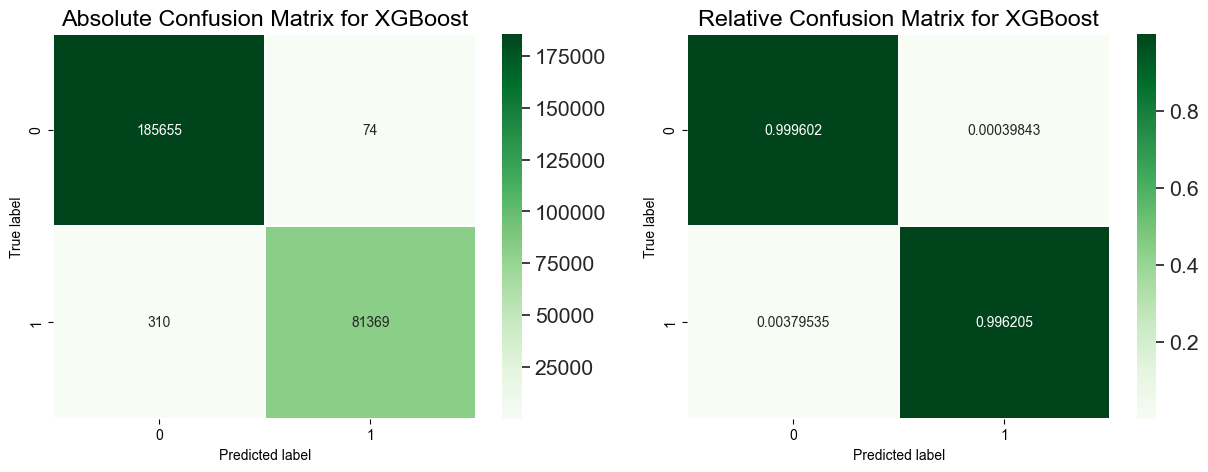

In [21]:
model = XGBoost_classification_tunned(best_hyperparams)

In [22]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

9


99.82295029743125
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}99.89 & 99.90 & 99.75 & 99.82 \\
\hline



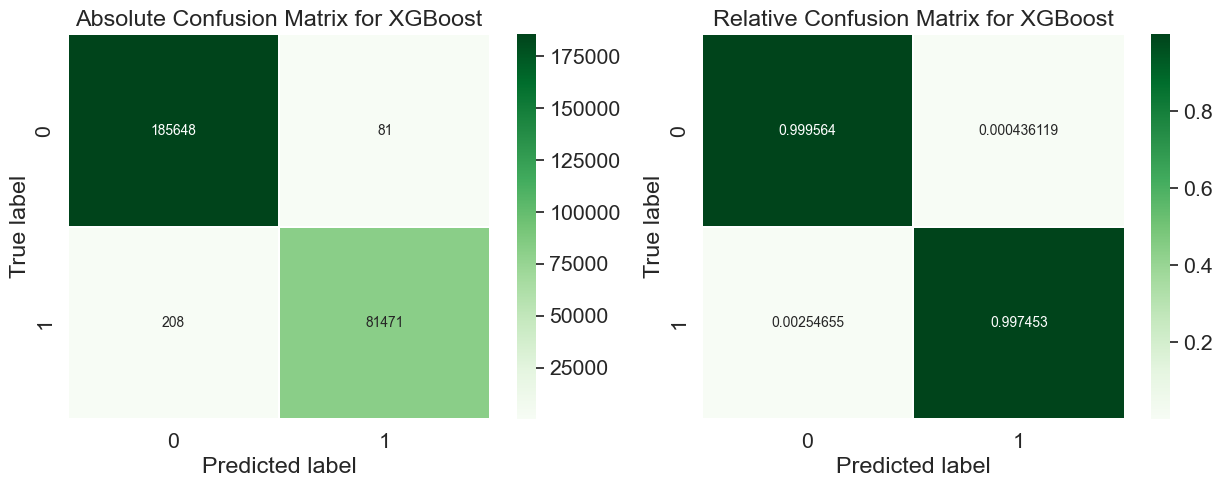

In [23]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=10)

# Evaluation of model

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}99.90 & 99.91 & 99.76 & 99.84 \\
\hline



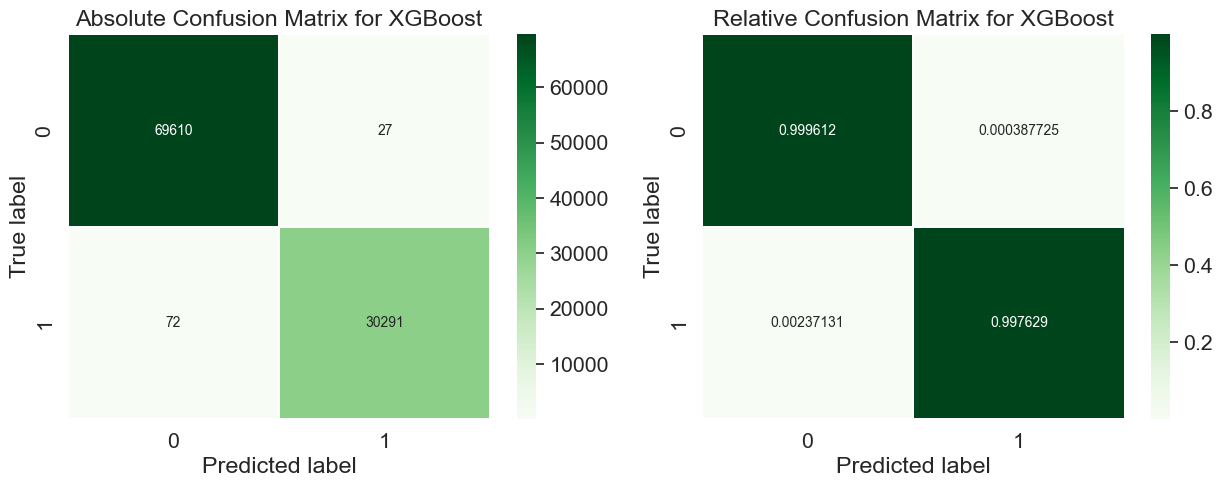

In [24]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [30]:
import csv

problem = "DoH_CIC"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

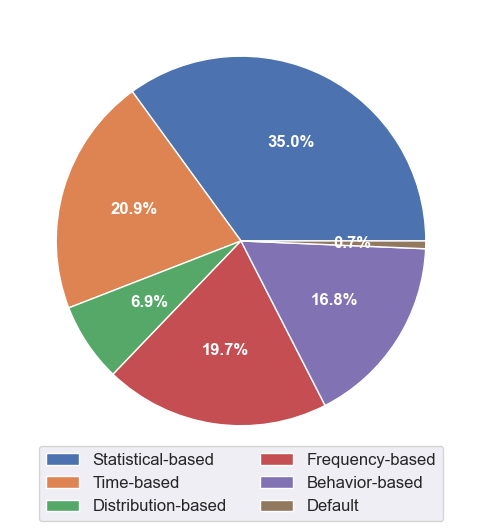

In [25]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()
f_def = feat_importances[default_faetures].sum() 

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf, f_def]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", "Default"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [26]:
data

[0.3501379, 0.20885396, 0.06929518, 0.19694567, 0.1680329, 0.0067344187]

In [27]:
feat_importances

PERIODICITY_SCDF            0.000000
GALTON_SKEWNESS             0.000000
BENFORD_LAW_PRESENTED       0.000000
AREA_VALUES_DISTRIBUTION    0.000000
SPECTRAL_BANDWIDTH          0.000000
                              ...   
Q3                          0.048114
POWER_MODE                  0.073138
MIN_DIFFTIMES               0.076912
MEDIAN                      0.082266
SIG_SPACES                  0.101164
Length: 76, dtype: float32

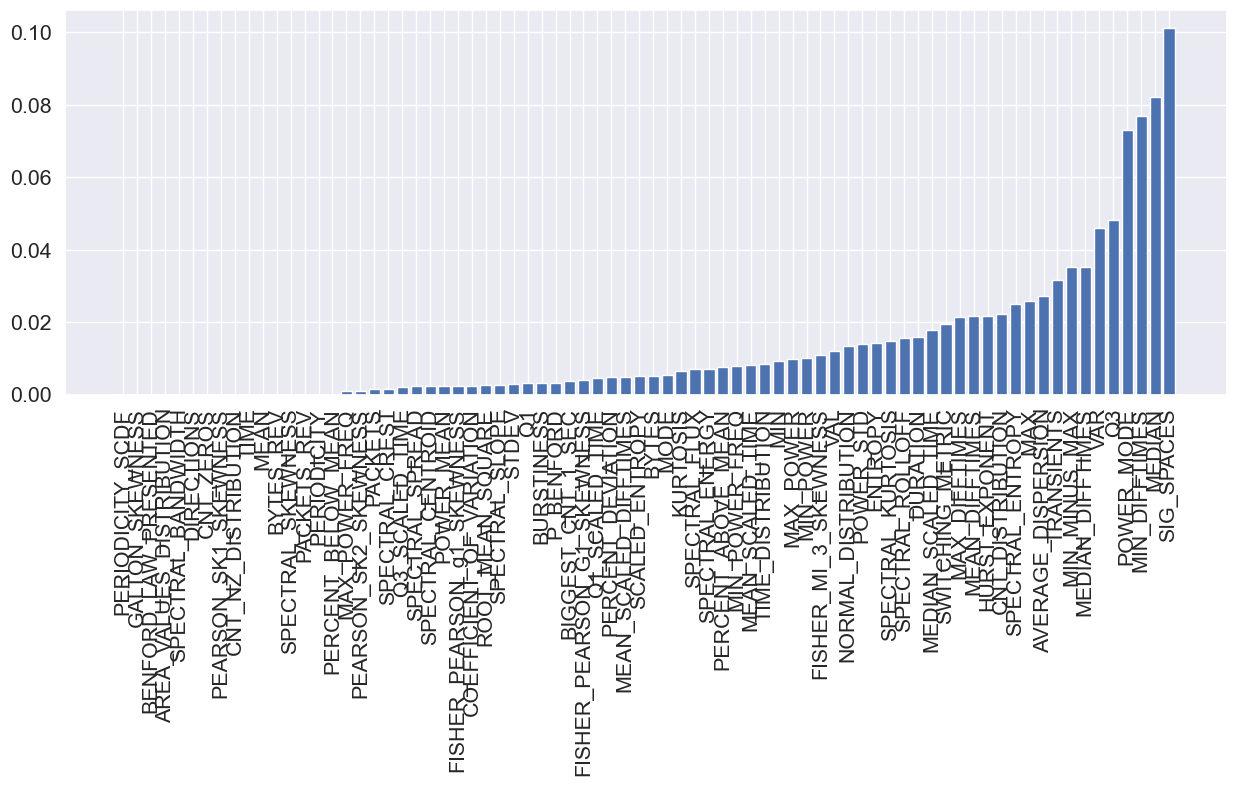

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [29]:
feat_importances.to_dict()

{'PERIODICITY_SCDF': 0.0,
 'GALTON_SKEWNESS': 0.0,
 'BENFORD_LAW_PRESENTED': 0.0,
 'AREA_VALUES_DISTRIBUTION': 0.0,
 'SPECTRAL_BANDWIDTH': 0.0,
 'DIRECTIONS': 0.0,
 'CNT_ZEROS': 0.0,
 'PEARSON_SK1_SKEWNESS': 0.0,
 'CNT_NZ_DISTRIBUTION': 0.0,
 'TIME': 0.0,
 'MEAN': 0.0,
 'BYTES_REV': 0.0,
 'SPECTRAL_SKEWNESS': 0.0,
 'PACKETS_REV': 0.0,
 'PERIODICITY': 0.0,
 'PERCENT_BELOW_MEAN': 0.0,
 'MAX_POWER_FREQ': 0.0009570932015776634,
 'PEARSON_SK2_SKEWNESS': 0.0011525291483849287,
 'PACKETS': 0.0014948856551200151,
 'SPECTRAL_CREST': 0.0015564670320600271,
 'Q3_SCALED_TIME': 0.002080689650028944,
 'SPECTRAL_SPREAD': 0.0023118439130485058,
 'SPECTRAL_CENTROID': 0.002343512140214443,
 'POWER_MEAN': 0.0023528942838311195,
 'FISHER_PEARSON_g1_SKEWNESS': 0.002365656429901719,
 'COEFFICIENT_OF_VARIATION': 0.002377285622060299,
 'ROOT_MEAN_SQUARE': 0.002655280288308859,
 'SPECTRAL_SLOPE': 0.002663404680788517,
 'STDEV': 0.0028518997132778168,
 'Q1': 0.0031339642591774464,
 'BURSTINESS': 0.0032549283932

# Feature selection

In [31]:
def perform_val(selected_features, best_hyperparams=None, cycles=10):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features.sample(100000), selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [32]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [04:47<00:00,  2.88s/trial, best loss: -0.982527249821986]
The best hyperparameters are :  

{'colsample_bytree': 0.21607465727366026, 'gamma': 2.7635835534533304, 'max_depth': 100.0, 'min_child_weight': 14.0, 'n_estimators': 300.0, 'reg_alpha': 1.0, 'reg_lambda': 0.9255959011571568}
100%|██████████| 100/100 [03:37<00:00,  2.17s/trial, best loss: -0.9855263157894737]
The best hyperparameters are :  

{'colsample_bytree': 0.16612474531961913, 'gamma': 3.585627759961905, 'max_depth': 80.0, 'min_child_weight': 17.0, 'n_estimators': 200.0, 'reg_alpha': 16.0, 'reg_lambda': 0.5999371006815093}
100%|██████████| 100/100 [02:49<00:00,  1.70s/trial, best loss: -0.9918921880135861]
The best hyperparameters are :  

{'colsample_bytree': 0.3574925961771054, 'gamma': 3.879422348016748, 'max_depth': 80.0, 'min_child_weight': 18.0, 'n_estimators': 200.0, 'reg_alpha': 4.0, 'reg_lambda': 0.338868429875885}
100%|██████████| 100/100 [05:05<00:00,  3.06s/trial, best loss: -0.990960

In [33]:
import csv

problem = "DoH_CIC"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])